In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10


2024-04-07 16:27:45.548566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 16:27:45.548617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 16:27:45.550171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Split training data into training and validation sets
split = int(0.8 * len(x_train))
x_val = x_train[split:]
x_train = x_train[:split]


In [4]:
# Reshape the data
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)


In [13]:
class VAELayer(tf.keras.layers.Layer):
    def __init__(self, latent_dim, beta=1.0):
        super(VAELayer, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta

    def build(self, input_shape):
        self.z_mean = self.add_weight(shape=(self.latent_dim,), initializer='zeros', trainable=True, name='z_mean')
        self.z_log_var = self.add_weight(shape=(self.latent_dim,), initializer='zeros', trainable=True, name='z_log_var')

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        # KL divergence loss with beta term
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss *= self.beta  # Multiply by beta
        self.add_loss(tf.reduce_mean(kl_loss))

        return z

# Function to build beta-VAE
def build_beta_vae(latent_dim, beta):
    # Define input layer
    input_img = Input(shape=(32, 32, 3))
    
    # Encoder
    x = Conv2D(64, (3, 3), strides=2, padding="same")(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Decoder
    x = Dense(8*8*128)(z)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((8, 8, 128))(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    output_img = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)

    # Define the model
    vae_out = VAELayer(latent_dim, beta=beta)([z_mean, z_log_var])
    vae = Model(input_img, vae_out)
    vae.compile(optimizer="adam")

    return vae


Epoch 1/15
 28/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3669

W0000 00:00:1712507843.744043    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9152

W0000 00:00:1712507847.145028    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712507848.367079    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.9131 - val_loss: 0.0123
Epoch 2/15
 22/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0163

W0000 00:00:1712507849.031373    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0123 - val_loss: 0.0053
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010 - val_loss: 9.6649e-04
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8157e-04 - val_loss: 8.8252e-04
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.7350e-04 - val_loss: 8.2699e-04
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.2967e-04 - val_loss: 8.2763e-04
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.9163e-04 - val_loss: 9.0852e-04
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.7512e-04 - val_loss: 7.7160e-04
Epoch 13/15
313/31

W0000 00:00:1712507883.970151    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 100.3162

W0000 00:00:1712507887.269806    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712507888.511321    1770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 100.0907 - val_loss: 7.9206
Epoch 2/15
 19/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3581

W0000 00:00:1712507889.105465    1771 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.0289 - val_loss: 0.7318
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5283 - val_loss: 0.4080
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3572 - val_loss: 0.2884
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2630 - val_loss: 0.2166
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2017 - val_loss: 0.1753
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1638 - val_loss: 0.1410
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1337 - val_loss: 0.1177
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1115 - val_loss: 0.0985
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0946 - val_loss: 0.0828
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0787 - val_loss: 0.0702
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0653 - val_loss: 0.0591
Epoch 13/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0

W0000 00:00:1712507924.142086    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9804

W0000 00:00:1712507927.428583    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712507928.735678    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 17.9375 - val_loss: 0.1414
Epoch 2/15
 22/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3228

W0000 00:00:1712507929.317003    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2600 - val_loss: 0.1323
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1238 - val_loss: 0.0889
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0749 - val_loss: 0.0617
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0517 - val_loss: 0.0431
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0386 - val_loss: 0.0330
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0295 - val_loss: 0.0266
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0235 - val_loss: 0.0225
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0198 - val_loss: 0.0181
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 13/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0

W0000 00:00:1712507964.303486    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 29.8832

W0000 00:00:1712507967.591541    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712507968.838902    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 29.8110 - val_loss: 0.3451
Epoch 2/15
 22/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2686

W0000 00:00:1712507969.403103    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1902 - val_loss: 0.0869
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0626 - val_loss: 0.0462
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0342 - val_loss: 0.0292
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0227 - val_loss: 0.0192
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - val_loss: 0.0177
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0160 - val_loss: 0.0199
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0230
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0224 - val_loss: 0.0276
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0242 - val_loss: 0.0220
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0249 - val_loss: 0.0141
Epoch 13/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0

W0000 00:00:1712508005.269334    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 53.0322

W0000 00:00:1712508008.568821    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712508009.805167    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 52.9017 - val_loss: 0.6471
Epoch 2/15
 17/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3596

W0000 00:00:1712508010.358507    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2332 - val_loss: 0.1331
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0914 - val_loss: 0.0668
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0518 - val_loss: 0.0415
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0349 - val_loss: 0.0317
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0275 - val_loss: 0.0304
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0269 - val_loss: 0.0262
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0298 - val_loss: 0.0358
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0337 - val_loss: 0.0454
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0415 - val_loss: 0.0361
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0439 - val_loss: 0.0233
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0456 - val_loss: 0.0712
Epoch 13/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0

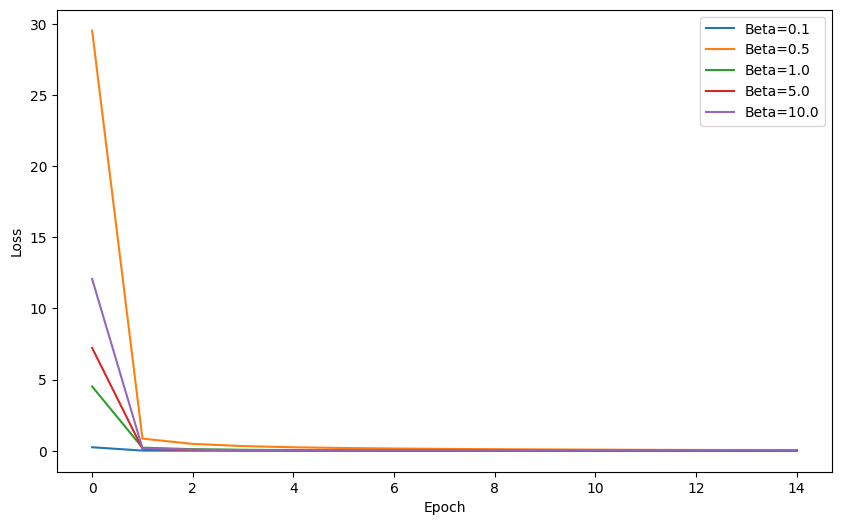

In [14]:
# Hyperparameter tuning for beta
beta_values = [0.1, 0.5, 1.0, 5.0, 10.0]  # Example values, you can adjust these
losses = []

for beta in beta_values:
    vae = build_beta_vae(latent_dim, beta)
    history = vae.fit(x_train, x_train, epochs=epochs, batch_size=128, validation_data=(x_val, x_val))
    losses.append(history.history['loss'])

# Plot losses
plt.figure(figsize=(10, 6))
for i, beta in enumerate(beta_values):
    plt.plot(losses[i], label=f'Beta={beta}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()